In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
PATH = './chest_xray'
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize((800,800)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]),
    'val':transforms.Compose([
        transforms.Resize((800,800)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=12,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_samples = {x: np.sum([1 for _ in os.listdir(os.path.join(PATH, 'train', x))]) for x in class_names}
weights = 1. / torch.tensor(list(class_samples.values()), dtype=torch.float).to(device)

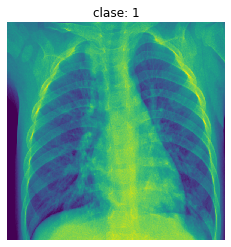

In [14]:
inputs, classes = next(iter(dataloaders['train']))
plt.imshow(inputs.numpy()[0,0], cmap='viridis')
plt.title(f'clase: {classes.numpy()[0]}');
plt.axis('off');

In [4]:
class CNN(nn.Module):
    def __init__(self, shape):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (3,3), padding=1)
        self.maxP1 = nn.MaxPool2d((2,2), stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.maxP2 = nn.MaxPool2d((2,2), stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 64, (3,3), padding=1)
        self.maxP3 = nn.MaxPool2d((2,2), stride=2, padding=0)
        self.conv4 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.maxP4 = nn.MaxPool2d((2,2), stride=2, padding=0)
        self.conv5 = nn.Conv2d(128, 256, (3,3), padding=1)
        self.maxP5 = nn.MaxPool2d((2,2), stride=2, padding=0)
        x = torch.rand(shape).view(-1,1,shape[0],shape[1])
        self.to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self.to_linear, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 2)
        
    def convs(self, x):
        x = self.maxP1(F.relu(self.conv1(x)))
        x = self.maxP2(F.relu(self.conv2(x)))
        x = self.maxP3(F.relu(self.conv3(x)))
        x = self.maxP4(F.relu(self.conv4(x)))
        x = self.maxP5(F.relu(self.conv5(x)))
        if self.to_linear is None:
            self.to_linear =  x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.to_linear)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        
cnn = CNN((800,800))
cnn = cnn.to(device)

In [5]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(cnn.parameters())

In [6]:
n_epochs = 10

train_loss, eval_loss = [],[]
for epoch in range(n_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            cnn.train()
        else:
            cnn.eval()
            
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = cnn(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    train_loss.append(loss.detach().to('cpu').numpy())
                else:
                    eval_loss.append(loss.to('cpu').numpy())

100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


In [7]:
t_loss = np.array(train_loss)
e_loss = np.array(eval_loss)

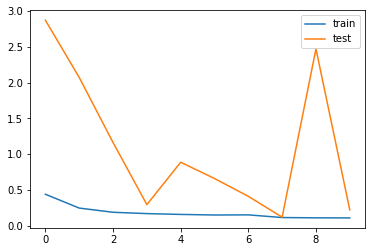

In [8]:
plt.plot(np.mean(t_loss.reshape(-1,len(t_loss)//n_epochs), axis=1), label='train');
plt.plot(np.mean(e_loss.reshape(-1,len(e_loss)//n_epochs), axis=1), label='test');
plt.legend();

In [9]:
cnn.eval()
aciertos = []
random = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    outputs = cnn(inputs)
    _, preds = torch.max(outputs, 1)
    aciertos.extend([i==j for i,j in zip(preds.to('cpu').numpy(), labels.numpy())])
    random.extend([np.random.randint(0,1)== i for i in labels.numpy()])

In [10]:
print(f'CNN Accuracy: {np.sum(aciertos)/len(aciertos)}')
print(f'Random Accuracy: {np.sum(random)/len(random)}')

CNN Accuracy: 0.9375
Random Accuracy: 0.5


In [11]:
torch.save(cnn.state_dict(), 'cnn_800_800_10e.pt')